## Imports

In [1]:
# Bibliotecas de manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from wordcloud import WordCloud
from prettytable import PrettyTable
from folium.plugins import HeatMap

# Processamento de texto
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Pré-processamento e modelagem de dados
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# Métricas de avaliação
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Outros
import pickle
import re
import warnings

warnings.filterwarnings("ignore")

C:\Users\Valmy\AppData\Local\Temp\ipykernel_6004\4205876107.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1 - EDA

In [2]:
# Realizando leitura do Dataset
data = pd.read_csv('Indicium_precificacao.csv')

# Exibindo informações acerca do conjunto de dados
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
# Verificando se os dados contêm valores nulos/NaN
data.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Abaixo está uma análise que realiza o cálculo e exibição da matriz de correlação entre os dados. A tabela de correlação mostra que não existe uma relação forte entre o preço e outras características presentes neste conjunto de dados

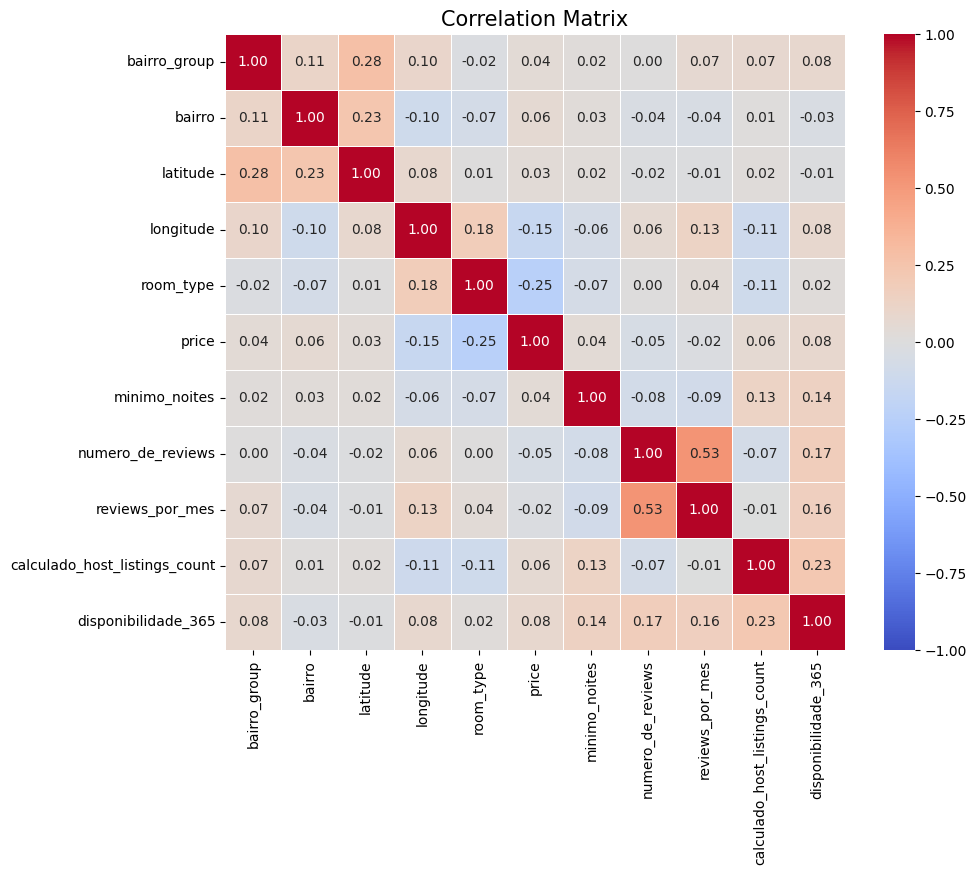

In [4]:
# Deletando colunas desnecessárias
data_model = data.drop(columns=['nome','id' ,'host_id','host_name','ultima_review'])

# Adicionando valores não nulos
data_model['reviews_por_mes'].fillna(data_model['reviews_por_mes'].mean(), inplace=True)

# Mapeando variáveis categóricas para numéricas para o cálculo da correlação
data_model['bairro_group'] = data_model['bairro_group'].astype("category").cat.codes
data_model['bairro'] = data_model['bairro'].astype("category").cat.codes
data_model['room_type'] = data_model['room_type'].astype("category").cat.codes

# Calculando a correlação
corr = data_model.corr(method='pearson')

# Plotando o gráfico da correlação
plt.figure(figsize=(10,8))
palette = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix",size=15)
plt.show()

A partir dos valores de longitude e latitude, podemos realizar análises geográficas sobre a localização das disponibilizações de aluguel e seus respectivos grupos de bairros, acompanhados de um mapa de calor. Com base em Nova York, observa-se uma maior concentração de imóveis nas áreas a oeste. (Talvez seja necessário rodar a célula para visualizar o mapa)

In [5]:
# Criando um mapa centrado em uma localização diferente
mapa = folium.Map([40.7128,-74.0060], zoom_start=10)

# Adicionando um mapa de calor com cores diferentes
HeatMap(data[['latitude', 'longitude']].dropna(), radius=10,
        gradient={0.2: 'blue', 0.4: 'yellow', 0.6: 'orange', 1.0: 'red'}).add_to(mapa)

# Exibindo o mapa
mapa

A seguir, temos uma análise que demonstra a relação entre os grupos de bairros e a quantidade de imóveis em cada um deles. Percebe-se que há uma grande discrepância na quantidade de imóveis entre Manhattan e Brooklyn em comparação com os outros grupos de bairros.

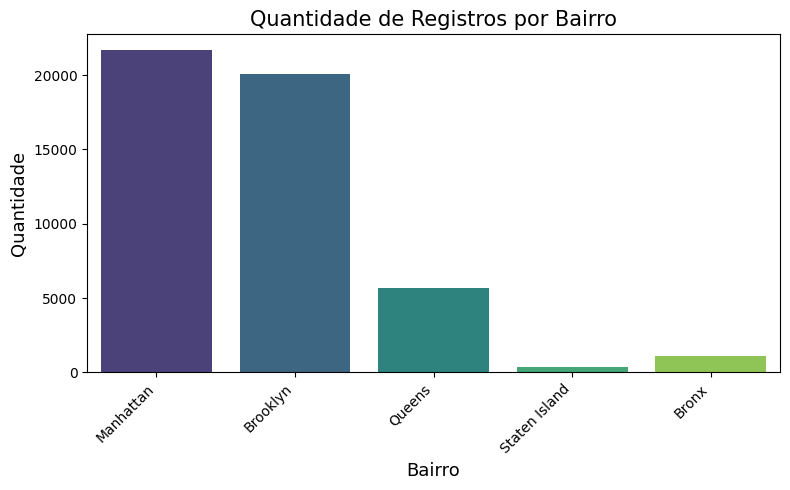

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='bairro_group', data=data, palette='viridis')

plt.xlabel("Bairro", size=13)
plt.ylabel("Quantidade", size=13)
plt.title("Quantidade de Registros por Bairro", size=15)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

Similarmente, conduzimos uma análise para investigar a relação entre os diferentes tipos de imóveis e sua distribuição quantitativa. Observa-se que as salas compartilhadas representam uma fração notavelmente menor em comparação com os outros dois tipos.

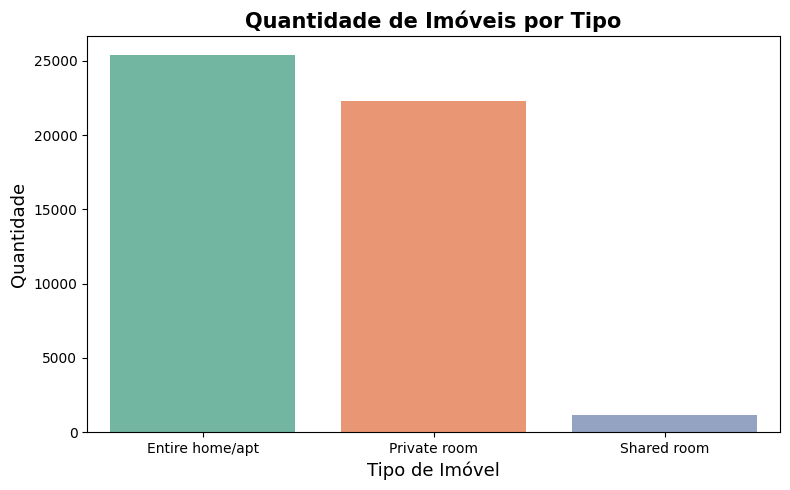

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x='room_type', data=data, palette='Set2')

plt.xlabel('Tipo de Imóvel', size=13)
plt.ylabel('Quantidade', size=13)
plt.title('Quantidade de Imóveis por Tipo', size=15, weight='bold')
plt.tight_layout()
plt.show()

O gráfico a seguir representa a relação entre o preço e o tipo de quarto. Observa-se que o preço dos quartos compartilhados é consistentemente inferior a 2.000. Em contraste, os quartos privados e as casas inteiras tendem a ter preços mais elevados em alguns casos.

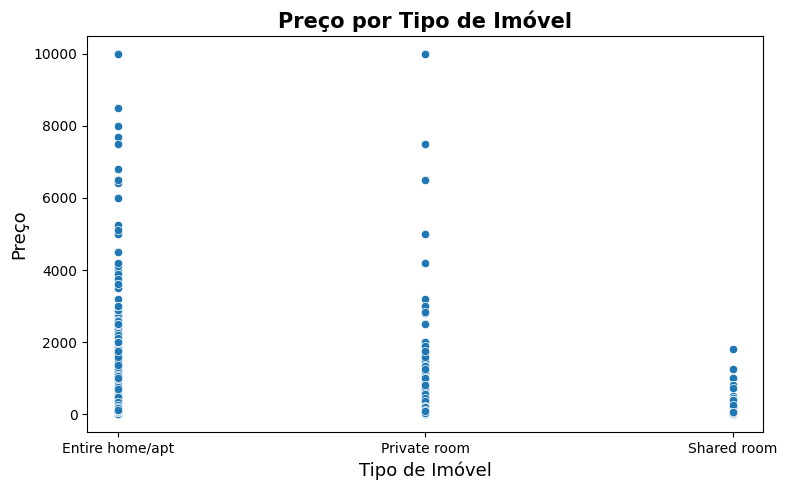

In [8]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='room_type', y='price', data=data, palette='Set2')

plt.xlabel("Tipo de Imóvel", size=13)
plt.ylabel("Preço", size=13)
plt.title("Preço por Tipo de Imóvel", size=15, weight='bold')
plt.tight_layout()
plt.show()

Nesta análise, explorei a relação entre os diferentes bairros e os preços dos imóveis, diferenciando também pelos tipos de imóveis. A representação visual revela como os preços variam entre os bairros para cada tipo de imóvel.

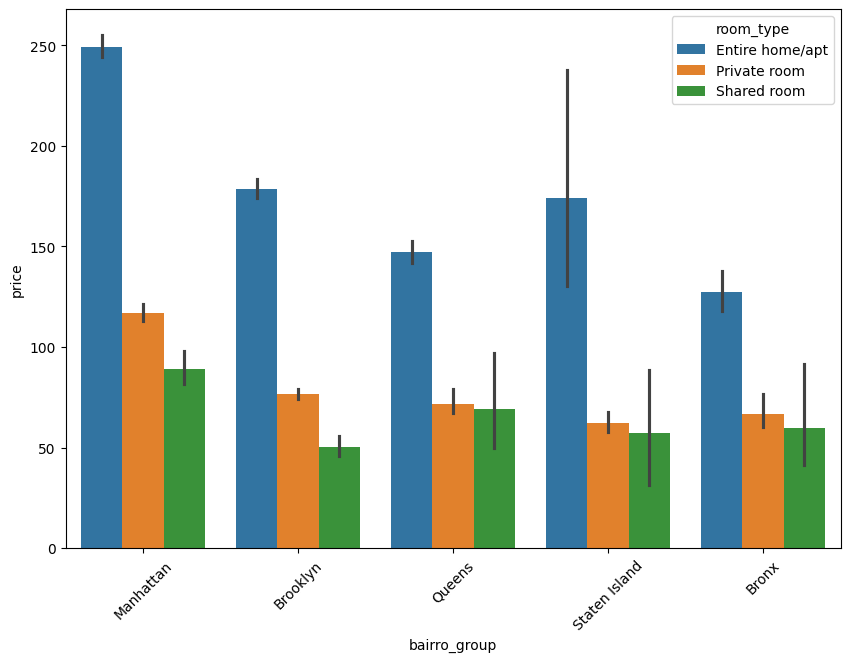

In [9]:
plt.figure(figsize=(10,7))
sns.barplot(x = "bairro_group", y = "price", hue = "room_type", data = data)
plt.xticks(rotation=45)
plt.show()

Top 10 bairros com maior quantidade de imóveis disponíveis para alugar.

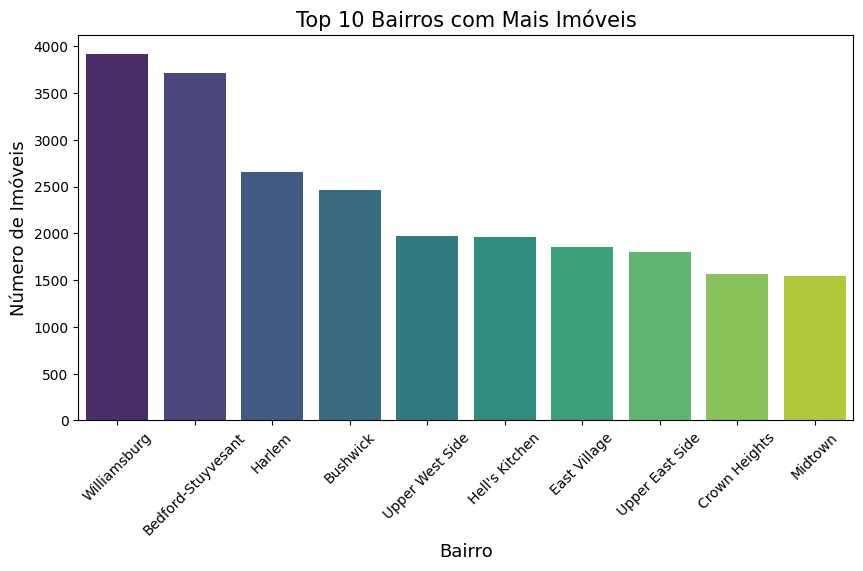

In [10]:
# Contagem do número de imóveis por bairro
top_10_bairros = data['bairro'].value_counts().nlargest(10)

# Configurações do gráfico
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_bairros.index, y=top_10_bairros.values, palette='viridis')

# Títulos e rótulos
plt.xlabel('Bairro', size=13)
plt.ylabel('Número de Imóveis', size=13)
plt.title('Top 10 Bairros com Mais Imóveis', size=15)
plt.xticks(rotation=45)
plt.show()

Top 10 regiões mais populares com base no índice de popularidade do host_id, calculado com base no número de reviews recebidas. Os hosts são agrupados por região para determinar a popularidade de cada uma, resultando em um gráfico das 10 regiões mais populares.

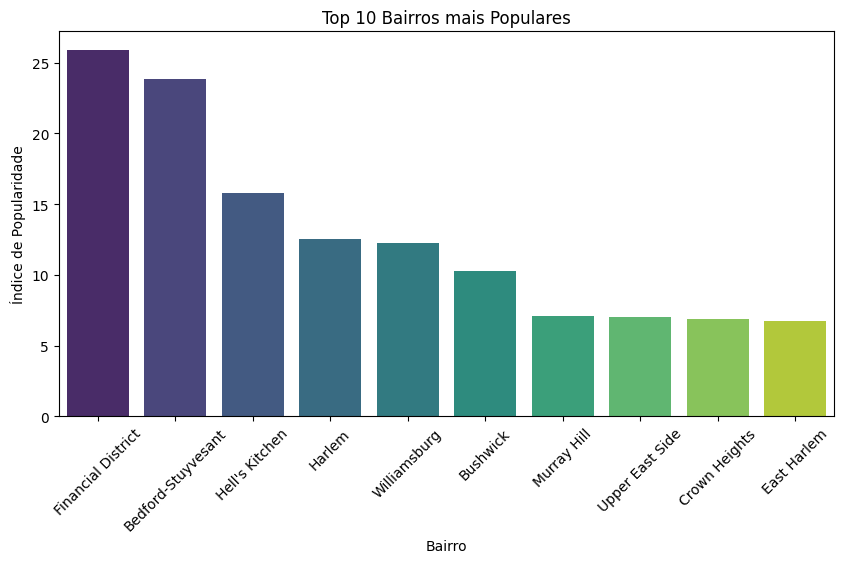

In [11]:
# Agrupando pelo ID do host e somando o número de reviews
data_model = data.groupby('host_id')['numero_de_reviews'].sum().reset_index()

# Encontrando o total de reviews
total_reviews = data['numero_de_reviews'].sum()

# Calculando o índice de popularidade
data_model['popularity_index'] = data_model['numero_de_reviews'] / total_reviews * 100

# Agrupando por bairro e somando os índices de popularidade
data_popular = data_model.merge(data[['host_id', 'bairro']], on='host_id')
data_popular = data_popular.groupby('bairro')['popularity_index'].sum().reset_index()

# Visualizando os 10 bairros mais populares
plt.figure(figsize=(10, 5))
sns.barplot(x='bairro', y='popularity_index', data=data_popular.sort_values('popularity_index', 
                                                                            ascending=False).head(10), palette='viridis')
plt.xlabel('Bairro')
plt.ylabel('Índice de Popularidade')
plt.title('Top 10 Bairros mais Populares')
plt.xticks(rotation=45)
plt.show()

## 2 - Questionário

### A) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Para descobrir isso, faremos uma análise de dados relacionados a apartamentos disponíveis para aluguel. O código inicialmente exibe os diferentes tipos de salas existentes e em seguida filtra apenas os apartamentos ('Entire home/apt'). Depois, calcula a média dos preços de aluguel, o número médio de análises, a média do número de dias disponíveis para reserva e a distribuição de apartamentos por grupo de bairro. Com base nesses dados, são criados quatro gráficos representando essas análises.

In [12]:
# Exibindo os tipos de salas existentes
opcoes = np.unique(data['room_type'])

for opcao in opcoes:
    print(opcao)

Entire home/apt
Private room
Shared room


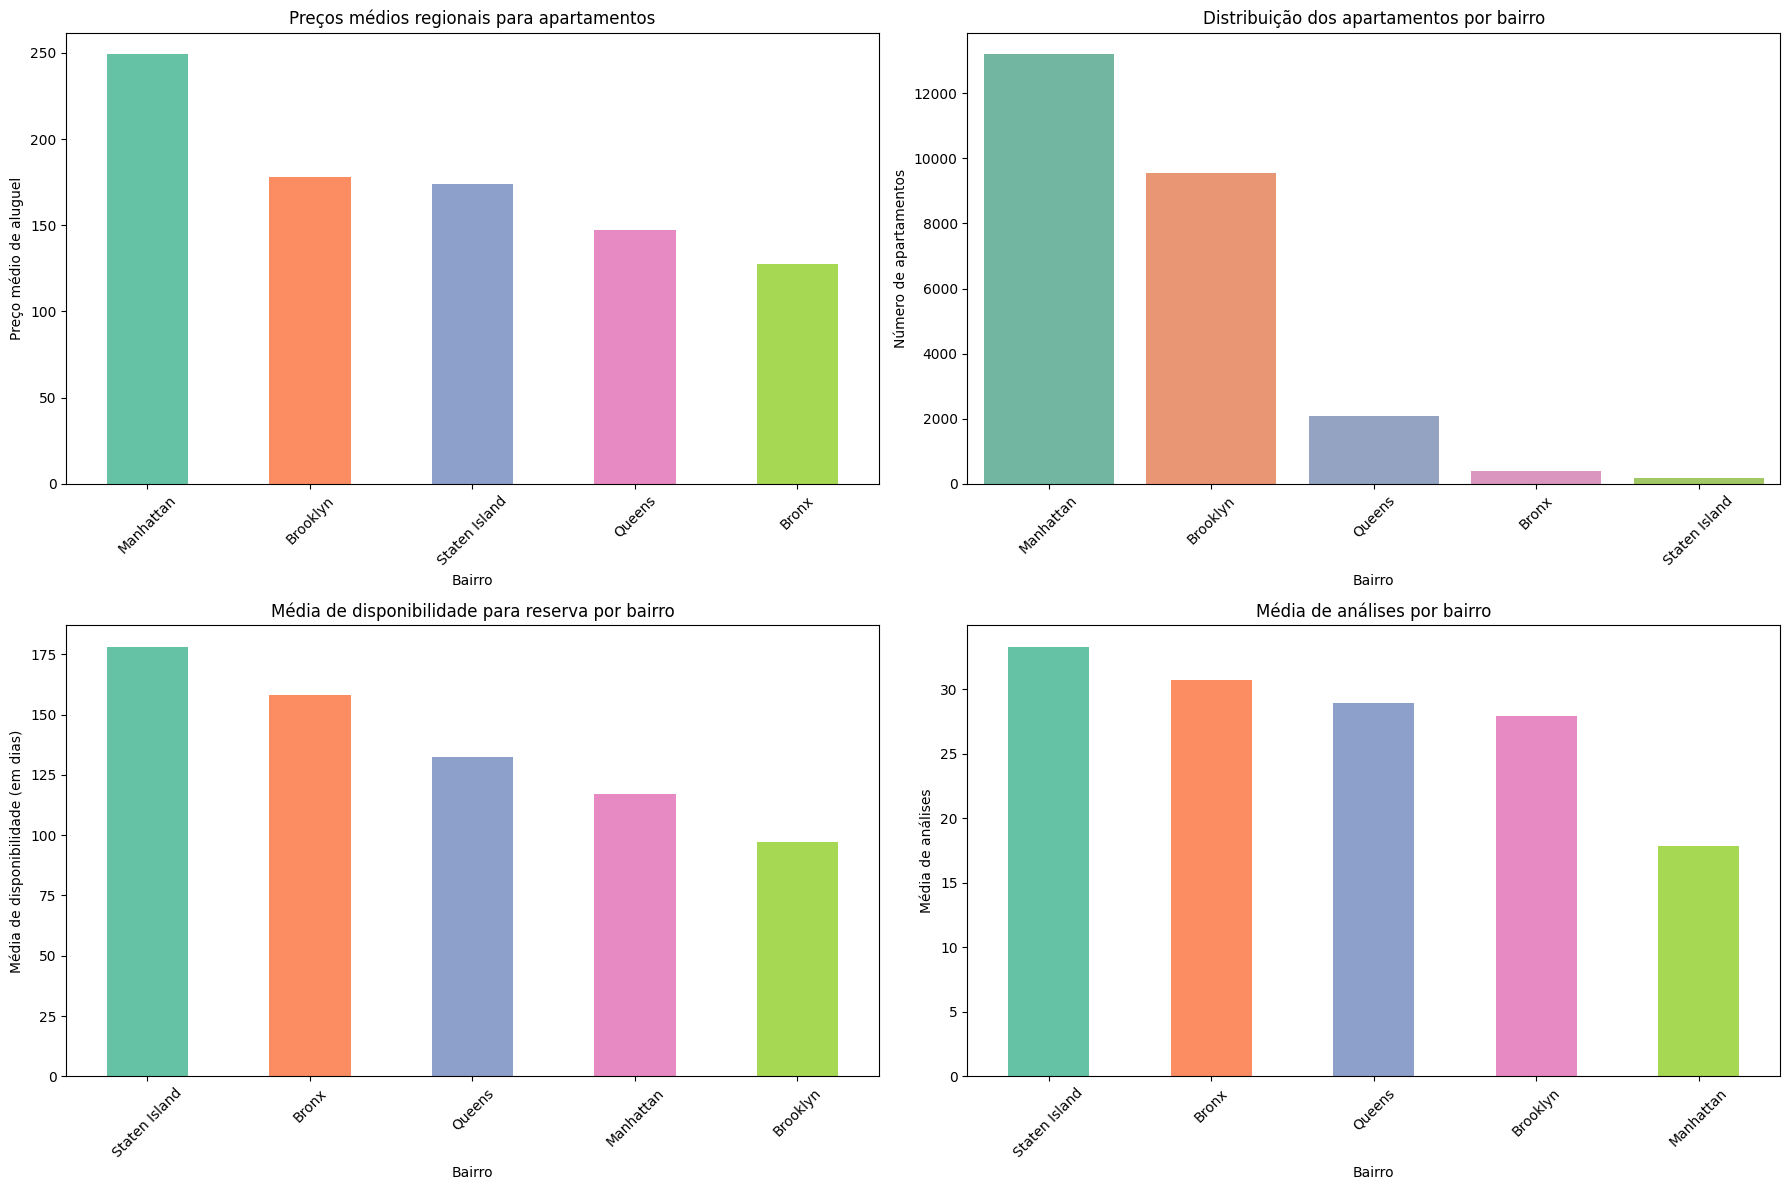

In [13]:
# Filtrar apenas as salas do tipo apartamento ('Entire home/apt')
apartamentos = data[data['room_type'] == 'Entire home/apt']

# Calcular a média dos preços de aluguel por bairro
media_preco = apartamentos.groupby('bairro_group')['price'].mean().sort_values(ascending=False)

# Calcular a média do número de análises por bairro
media_reviews = apartamentos.groupby('bairro_group')['numero_de_reviews'].mean().sort_values(ascending=False)

# Calcular a média do número de dias disponíveis para reserva por bairro
media_disponibilidade = apartamentos.groupby('bairro_group')['disponibilidade_365'].mean().sort_values(ascending=False)

# Definir uma paleta de cores
colors = sns.color_palette('Set2', len(media_preco))

# Configuração dos subplots
plt.figure(figsize=(18, 12))

# Gráfico 1: Preço médio de aluguel por bairro
plt.subplot(2, 2, 1)
media_preco.plot(kind='bar', color=colors)
plt.ylabel('Preço médio de aluguel')
plt.xlabel('Bairro')
plt.title('Preços médios regionais para apartamentos')
plt.xticks(rotation=45)

# Gráfico 2: Distribuição dos apartamentos por bairro
plt.subplot(2, 2, 2)
sns.countplot(x='bairro_group', data=apartamentos, palette=colors)
plt.title('Distribuição dos apartamentos por bairro')
plt.xlabel('Bairro')
plt.ylabel('Número de apartamentos')
plt.xticks(rotation=45)

# Gráfico 3: Média do número de dias disponíveis para reserva por bairro
plt.subplot(2, 2, 3)
media_disponibilidade.plot(kind='bar', color=colors)
plt.ylabel('Média de disponibilidade (em dias)')
plt.xlabel('Bairro')
plt.title('Média de disponibilidade para reserva por bairro')
plt.xticks(rotation=45)

# Gráfico 4: Média do número de análises por bairro
plt.subplot(2, 2, 4)
media_reviews.plot(kind='bar', color=colors)
plt.ylabel('Média de análises')
plt.xlabel('Bairro')
plt.title('Média de análises por bairro')
plt.xticks(rotation=45)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

plt.show()

R = Portanto, com base nas análises, se o investidor estiver disposto a assumir um investimento mais robusto, pode ser vantajoso investir em um apartamento em Manhattan devido à alta demanda por aluguéis e aos preços médios mais elevados. Alternativamente, investir em Staten Island pode ser uma opção viável, pois, apesar da demanda menor, os preços médios são altos, indicando uma região mais próspera, com boa disponibilidade de reservas e avaliações favoráveis. Para investidores buscando custos iniciais mais econômicos, pode ser mais adequado investir em um apartamento no Brooklyn, que apresenta alta demanda por aluguéis e preços medianos mais acessíveis em comparação com Staten Island. Outra opção seria o Queens, com preços médios mais baixos, embora balanceados nas demais categorias de análise.

### B) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Já foi analisado anteriormente que as variáveis do dataset não têm muita relação com o preço, por meio da matriz de correlação, embora possamos fazer uma análise mais específica. Para realizar essa análise, primeiro selecionamos as colunas relevantes: preço, número mínimo de noites e disponibilidade ao longo do ano. Em seguida, criamos gráficos de dispersão para explorar a relação entre o preço de aluguel e o número mínimo de noites, assim como entre o preço de aluguel e a disponibilidade ao longo do ano. Cada gráfico apresenta pontos que representam essas relações, permitindo uma visualização clara dos padrões de comportamento dos dados.

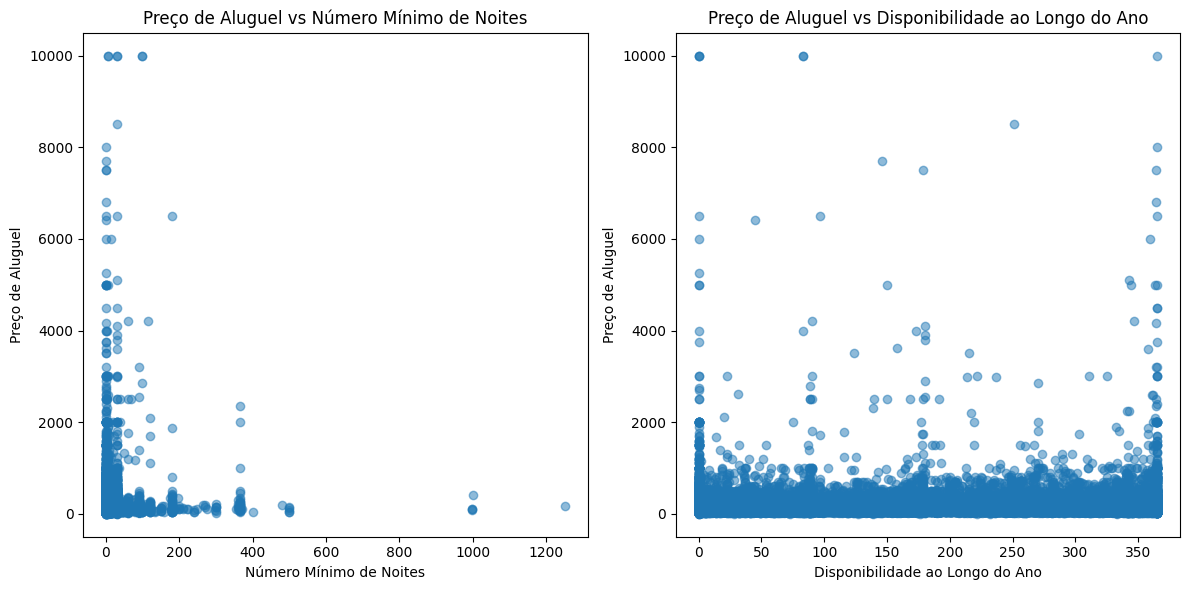

In [14]:
# Selecionar as colunas de interesse
colunas_interesse = ['price', 'minimo_noites', 'disponibilidade_365']
dados_interesse = data[colunas_interesse]

# Criar gráficos de dispersão
plt.figure(figsize=(12, 6))

# Gráfico de dispersão para preço de aluguel vs número mínimo de noites
plt.subplot(1, 2, 1)
plt.scatter(dados_interesse['minimo_noites'], dados_interesse['price'], alpha=0.5)
plt.title('Preço de Aluguel vs Número Mínimo de Noites')
plt.xlabel('Número Mínimo de Noites')
plt.ylabel('Preço de Aluguel')

# Gráfico de dispersão para preço de aluguel vs disponibilidade ao longo do ano
plt.subplot(1, 2, 2)
plt.scatter(dados_interesse['disponibilidade_365'], dados_interesse['price'], alpha=0.5)
plt.title('Preço de Aluguel vs Disponibilidade ao Longo do Ano')
plt.xlabel('Disponibilidade ao Longo do Ano')
plt.ylabel('Preço de Aluguel')

plt.tight_layout()
plt.show()

R = Portanto, ao analisar os gráficos, observamos que tanto o número de noites quanto a disponibilidade ao longo do ano têm pouca influência sobre o preço, não apresentando uma característica específica. A matriz de correlação confirma isso, mostrando uma correlação de aproximadamente 0.043 entre o preço de aluguel e o número mínimo de noites, indicando uma correlação muito fraca próxima de zero. Isso sugere que não há uma relação linear significativa entre esses dois fatores. Da mesma forma, a correlação entre o preço de aluguel e a disponibilidade ao longo do ano é de aproximadamente 0.082, também indicando uma correlação muito fraca. Em outras palavras, nem o número mínimo de noites nem a disponibilidade ao longo do ano parecem ter um impacto substancial no preço do aluguel.

### C) Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Para realizar a análise de dados textual e identificar padrões nas descrições de imóveis agrupados por faixa de preço, são definidas funções para tratamento de texto, incluindo remoção de caracteres especiais e stopwords, além da lematização do texto. Os dados são preparados, preenchendo valores nulos na coluna 'nome', convertendo o texto para minúsculas e removendo stopwords e caracteres especiais.

In [15]:
def remove_characters(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in word_tokenize(text) if word.lower() not in stop_words]
    return ' '.join(tokens)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    return ' '.join(lemmatized_tokens)

df = data
df['nome'].fillna('', inplace=True)
df['nome'] = df['nome'].apply(lambda x: x.lower())
df['nome'] = df['nome'].apply(lambda x: remove_stopwords(x))
df['nome'] = df['nome'].apply(lambda x: remove_characters(x))

Com isso, os dados são divididos em grupos com base na faixa de preço usando a função qcut do pandas. Em seguida, é iterado sobre cada grupo e é criada uma nuvem de palavras para as descrições dos apartamentos nesse grupo. A nuvem de palavras mostra as palavras mais frequentes nas descrições desse grupo específico, proporcionando uma visualização dos termos mais relevantes associados a diferentes faixas de preço de aluguel. Cada nuvem de palavras é exibida em um gráfico separado.

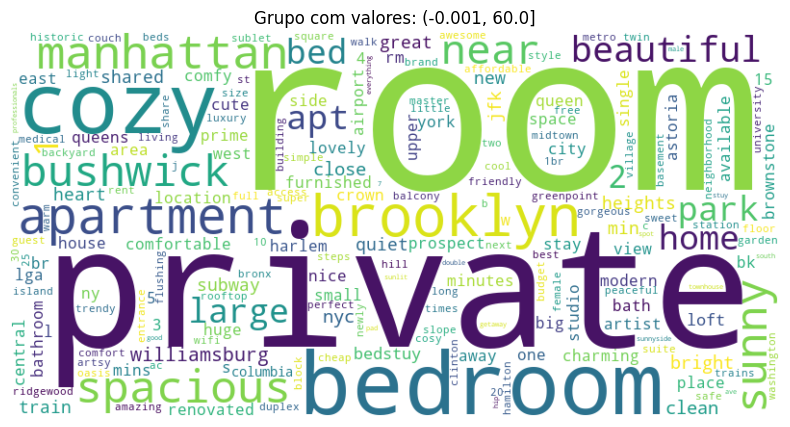

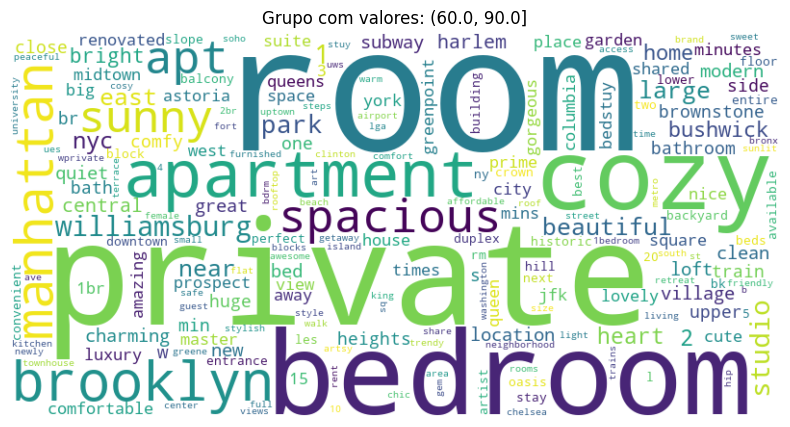

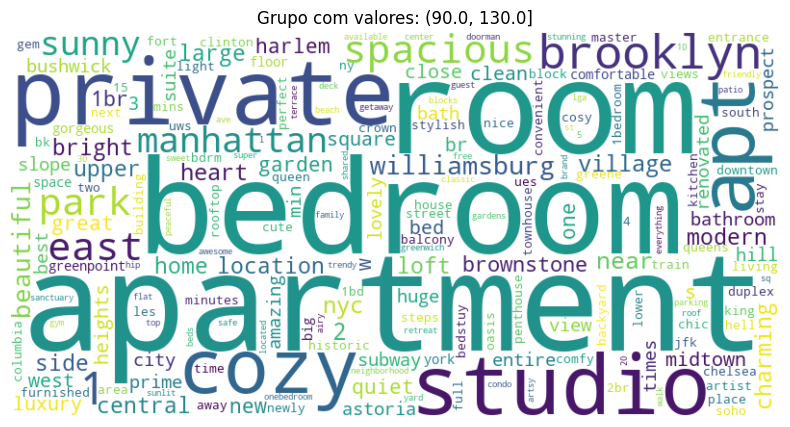

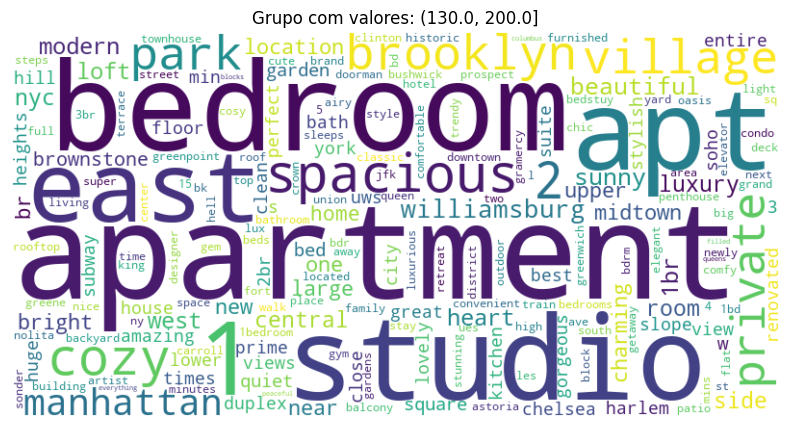

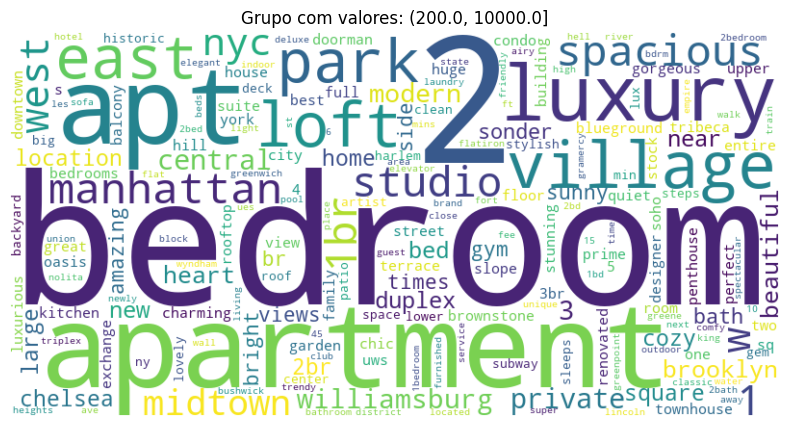

In [16]:
# Dividir os dados em grupos por faixa de preço
num_grupos = 5  # Defina o número de grupos desejados
intervalo_preco = pd.qcut(df['price'], num_grupos)

# Iterar sobre os grupos e criar uma nuvem de palavras para cada grupo
for grupo, df_grupo in df.groupby(intervalo_preco):
    # Contagem de frequência de palavras no grupo atual
    word_freq = {}
    for nome in df_grupo['nome']:
        for palavra in nome.split():
            if palavra in word_freq:
                word_freq[palavra] += 1
            else:
                word_freq[palavra] = 1
    
    # Criar uma nuvem de palavras com as palavras mais frequentes no grupo atual
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Grupo com valores: {grupo}')
    plt.axis('off')
    plt.show()

R = A partir da visualização dos WordClouds, parece sim existir um padrão no texto do nome do local para lugares de mais alto valor, apesar de palavras serem comuns entre os grupos. Observa-se que, nos grupos de valores mais altos, palavras como "luxury", "loft", "village", "midtown" e "duplex" aparecem com mais frequência. Isso sugere que certos adjetivos e características específicas estão associados a lugares de mais alto valor.

## 3 - Previsão

Para realizar a previsão, os dados serão utilizados em modelos de machine learning, no qual foi utilizado a biblioteca do sklearn para este propósito

In [17]:
# Recuperando a fonte de dados
_data = data
_data.info()
_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48894 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,village harlem new york,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,cozy entire floor brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,entire apt spacious studioloft central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,large cozy 1 br apartment midtown east,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


### Tratamento

Foi optado pela exclusão das colunas 'nome', 'id', 'host_id', 'host_name', 'ultima_review', por serem dados que não contem muito relevância para previsão de preço. Ja que o 'id' seria um identificador para cada imóvel, o 'nome' representa o nome do anuncio, ou seja, é algo manualmente escrito, 'host_id' por motivos similares do 'id', e a 'ultima_review', no qual seria uma data, que para esse problema é irrelevante, pois não temos alguma característica de situação temporal.

In [18]:
# Eliminar colunas desnecessárias
_data = _data.drop(columns=['nome', 'id', 'host_id', 'host_name', 'ultima_review'])

In [19]:
# verificar valores nulos
_data.isnull().sum()

bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [20]:
# Preencher valores faltantes
_data['reviews_por_mes'].fillna(_data['reviews_por_mes'].mean(), inplace=True)

### Transformações

Algumas transformações foram realizadas no conjunto de dados. Primeiramente, estamos convertendo as variáveis categóricas em valores numéricos usando Label Encoder. Isso é feito para permitir que os modelos de aprendizado de máquina operem com essas variáveis, uma vez que eles requerem valores numéricos como entrada. Cada categoria única é mapeada para um número único, simplificando a análise dos dados pelo modelo.

Em seguida, os dados foram divididos em variáveis de entrada (X) e variável de saída (y). A variável de entrada (X) consiste em todas as colunas, exceto a coluna de preço, que é a variável que estamos tentando prever. A variável de saída (y) é a coluna de preço, porém, foi aplicada uma transformação logarítmica para garantir uma distribuição mais normal dos dados.

Após essa etapa, os dados foram normalizados utilizando a classe StandardScaler. A normalização é importante para garantir que todas as variáveis tenham a mesma escala, o que ajuda os modelos de aprendizado de máquina a convergirem mais rapidamente e a evitarem que características com grande magnitude dominem as demais durante o treinamento.

In [21]:
# Mapeamento de variáveis categóricas (Label Encoder)
_data['bairro_group'] = _data['bairro_group'].astype("category").cat.codes
_data['bairro'] = _data['bairro'].astype("category").cat.codes
_data['room_type'] = _data['room_type'].astype("category").cat.codes

In [22]:
_data.head()

,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2,127,40.75362,-73.98377,0,225,1,45,0.380000,2,355
1,2,94,40.80902,-73.94190,1,150,3,0,1.373251,1,365
2,1,41,40.68514,-73.95976,0,89,1,270,4.640000,1,194
3,2,61,40.79851,-73.94399,0,80,10,9,0.100000,1,0
4,2,137,40.74767,-73.97500,0,200,3,74,0.590000,1,129


In [23]:
# Divisão os dados
X = _data.drop(columns=['price']).values
y = np.log1p(_data['price']).values

# Normalização dos dados X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Treinamento

O problema em questão se configura em um problema de regressão, pois queremos prever um valor contínuo, que no caso é o preço do aluguel. Após a preparação dos dados, diversos modelos de regressão foram avaliados para prever o preço dos aluguéis. Três modelos foram testados: Regressão Linear, Random Forest e MLP. Para avaliar o desempenho de cada modelo, foi utilizada a técnica de validação cruzada com k-folds, onde os dados foram divididos em cinco conjuntos distintos para treinamento e teste, garantindo uma avaliação robusta.

Durante o treinamento de cada modelo, foram registradas as métricas de desempenho RMSE e R² para cada fold. O RMSE representa a raiz quadrada da média dos erros quadráticos entre os valores previstos e os valores reais do preço dos aluguéis, sendo que quanto mais próximo de 0, melhor. Já o R² mede a proporção da variância na variável dependente que é previsível a partir da variável independente, sendo uma medida de quão bem o modelo se ajusta aos dados, e quanto mais próximo de 1, melhor.

Após a validação cruzada, o RMSE foi escolhido como métrica principal devido à sua ampla utilização em problemas de regressão e sua capacidade de penalizar erros maiores de forma mais significativa, fornecendo uma indicação clara da precisão do modelo na previsão dos preços dos aluguéis. O modelo com o menor RMSE foi selecionado como o melhor para prever os preços dos aluguéis, indicando uma precisão mais alta na previsão. Esse modelo foi salvo como 'best_model.pkl' para uso futuro.

In [24]:
# Definição dos modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Definir o número de folds para a validação cruzada
k_folds = 5

# Inicializar o objeto KFold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Variáveis para acompanhar o melhor desempenho
best_rmse = float('inf')
best_r2 = float('inf')
best_model_name = None
best_model = None

# Loop sobre cada modelo
for model_name, model in models.items():
    # Lista para armazenar as métricas de avaliação de cada fold
    rmse_scores = []
    r2_scores   = []
    
    # Loop sobre cada fold
    for train_index, test_index in kf.split(X_scaled):
        X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        # Treinar o modelo com os dados de treinamento do fold atual
        model.fit(X_train_fold, y_train_fold)
        
        # Prever os valores do conjunto de teste do fold atual
        y_pred_fold = model.predict(X_test_fold)
        
        # Calcular o RMSE para o fold atual
        rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
        rmse_scores.append(rmse_fold)

        # Calcular o R² para o fold atual
        r2_fold = r2_score(y_test_fold, y_pred_fold)
        r2_scores.append(r2_fold)
    
    # Calcular a média do RMSE para o modelo atual
    avg_rmse = np.mean(rmse_scores)

    # Calcular a média do R² para o modelo atual
    avg_r2 = np.mean(r2_scores)
    
    # Verificar se o desempenho deste modelo é melhor do que o melhor até agora
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_r2   = avg_r2
        best_model_name = model_name
        best_model = model
        
# Criar uma tabela para acomodar os resultados
table = PrettyTable()

# Adicionar colunas
table.field_names = ["Metric", "Value"]

# Adicionar linhas com os resultados
table.add_row(["Best Model", best_model_name])
table.add_row(["Best RMSE", "{:.2f}".format(best_rmse)])
table.add_row(["Best R2", "{:.2f}".format(best_r2)])

# Imprimir a tabela
print(table)

# Salvar o melhor modelo treinado
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

+------------+---------------+
|   Metric   |     Value     |
+------------+---------------+
| Best Model | Random Forest |
| Best RMSE  |      0.44     |
|  Best R2   |      0.60     |
+------------+---------------+


Com base na saída fornecida, o modelo que melhor se aproxima dos dados é o Random Forest Regressor, apresentando um RMSE de 0.45 e um R² de 0.59. O Random Forest oferece uma série de vantagens, incluindo robustez contra overfitting devido à sua natureza de conjunto de árvores de decisão, capacidade de lidar com dados heterogêneos sem muita preparação e habilidade de capturar relações não lineares entre os recursos e o alvo. No entanto, o modelo também possui desafios, como sua complexidade, o que pode tornar a interpretação dos resultados mais difícil, e o tempo de treinamento potencialmente longo, especialmente em conjuntos de dados maiores.

# 4 - Inferência

Para sugerir um preço, iremos utilizar o modelo previamente treinado juntamente com os novos dados sugeridos, o que implica realizar uma inferência.

In [25]:
data_inf = {'id': 2595,
'nome': 'Skylit Midtown Castle',
'host_id': 2845,
'host_name': 'Jennifer',
'bairro_group': 'Manhattan',
'bairro': 'Midtown',
'latitude': 40.75362,
'longitude': -73.98377,
'room_type': 'Entire home/apt',
'price': 225,
'minimo_noites': 1,
'numero_de_reviews': 45,
'ultima_review': '2019-05-21',
'reviews_por_mes': 0.38,
'calculado_host_listings_count': 2,
'disponibilidade_365': 355}

new_df = pd.DataFrame([data_inf])
new_df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


Antes de efetivamente utilizar os dados no modelo, é necessário realizar os mesmos procedimentos de tratamento e transformações de dados que foram utilizados e explicados na fase de treinamento.

In [26]:
# Remover as colunas irrelevantes e a variável de preço
new_df = new_df.drop(columns=['nome', 'id', 'host_id', 'host_name', 'ultima_review', 'price'])

# Converter colunas categóricas em códigos numéricos
new_df['bairro_group'] = new_df['bairro_group'].astype("category").cat.codes
new_df['bairro'] = new_df['bairro'].astype("category").cat.codes
new_df['room_type'] = new_df['room_type'].astype("category").cat.codes

# Aplicar transformação de escala
new_X = scaler.transform(new_df)

In [27]:
# Carregar o modelo treinado salvo em .pkl
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

In [28]:
# Fazer a previsão do preço usando o modelo treinado
predicted_price = model.predict(new_X)

# Criar uma tabela para exibição
table = PrettyTable()

# Adicionar colunas
table.field_names = ["Description", "Price"]

# Adicionar a previsão
table.add_row(["Predicted price", round(np.expm1(predicted_price)[0], 2)])

# Adicionar o preço original
table.add_row(["Original price", data_inf['price']])

# Imprimir a tabela
print(table)

+-----------------+--------+
|   Description   | Price  |
+-----------------+--------+
| Predicted price | 301.45 |
|  Original price |  225   |
+-----------------+--------+


Portanto, a sugestão de preço que o modelo de aprendizado de máquina sugeriu para o novo conjunto de dados foi de 279.27